# **MBP1413H Model Training Tutorial With Google Colab**
This tutorial was written by [Ahmadreza Attarpour](https://github.com/AAttarpour) for MBP1413H.

I used sections of [this tutorial](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb) from MONAI.

# **Introduction and Aim**

***Objective:*** The tutorial aims to demonstrate the integration of MONAI and PyTorch libraries for developing a DL model for Spleen segmentation.

***Features Highlighted:***

* Utilization of MONAI's transforms for dictionary format data, enabling flexible data augmentation and preprocessing.

* Utilization of caching I/O and transforms to accelerate both training and validation processes, reducing computational overhead.

* Implementation of a 3D UNet model,train it and save the trained model.

* Employing Dice loss function and Mean Dice metric for accurate and robust segmentation in 3D space and model evaluation.


* Application of sliding window inference method, allowing efficient processing of large images by dividing them into overlapping patches.


***Dataset Overview:***
* Task: Spleen segmentation.
* Modality: Computed Tomography (CT).
* Dataset Size: 61 3D volumes, comprising 41 for training and 20 for testing.
* Source: Memorial Sloan Kettering Cancer Center.




# **Section 1: Setup environment**




In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 19.6 MB/s eta 0:00:00


In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.4.dev2406
Numpy version: 1.23.5
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e4576456e01f35d1753f0c8fd1e6dc8a61b1f6e0
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.1
gdown version: 4.7.3
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.35.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp27x49r3l


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.


* Task: Spleen segmentation
* Target: Spleen  
* Modality: CT  
* Size: 61 3D volumes (41 Training + 20 Testing)  
* Source: Memorial Sloan Kettering Cancer Center  
* Challenge: Large ranging foreground size

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [03:26, 7.78MB/s]                            

2024-02-13 16:33:39,522 - INFO - Downloaded: /tmp/tmp27x49r3l/Task09_Spleen.tar


2024-02-13 16:33:42,438 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2024-02-13 16:33:42,439 - INFO - Writing into directory: /tmp/tmp27x49r3l.


In [ ]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [ ]:
print(f"training data: {train_files}")
print(f"validating data: {val_files}")

training data: [{'image': '/tmp/tmp27x49r3l/Task09_Spleen/imagesTr/spleen_10.nii.gz', 'label': '/tmp/tmp27x49r3l/Task09_Spleen/labelsTr/spleen_10.nii.gz'}, {'image': '/tmp/tmp27x49r3l/Task09_Spleen/imagesTr/spleen_12.nii.gz', 'label': '/tmp/tmp27x49r3l/Task09_Spleen/labelsTr/spleen_12.nii.gz'}, {'image': '/tmp/tmp27x49r3l/Task09_Spleen/imagesTr/spleen_13.nii.gz', 'label': '/tmp/tmp27x49r3l/Task09_Spleen/labelsTr/spleen_13.nii.gz'}, {'image': '/tmp/tmp27x49r3l/Task09_Spleen/imagesTr/spleen_14.nii.gz', 'label': '/tmp/tmp27x49r3l/Task09_Spleen/labelsTr/spleen_14.nii.gz'}, {'image': '/tmp/tmp27x49r3l/Task09_Spleen/imagesTr/spleen_16.nii.gz', 'label': '/tmp/tmp27x49r3l/Task09_Spleen/labelsTr/spleen_16.nii.gz'}, {'image': '/tmp/tmp27x49r3l/Task09_Spleen/imagesTr/spleen_17.nii.gz', 'label': '/tmp/tmp27x49r3l/Task09_Spleen/labelsTr/spleen_17.nii.gz'}, {'image': '/tmp/tmp27x49r3l/Task09_Spleen/imagesTr/spleen_18.nii.gz', 'label': '/tmp/tmp27x49r3l/Task09_Spleen/labelsTr/spleen_18.nii.gz'}, {'im

## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

# **Section 2:  Set up data loader and augmentation transforms**


## MONAI [transforms](https://docs.monai.io/en/latest/transforms.html)


## Transforms using MONAI Compose
we can create a compose file that contains the list of all transforms we want to apply on each image.
1. LoadImaged:serves as the initial step in the data augmentation process, importing both spleen CT images and their corresponding labels from NIfTI format files. This step is crucial for accessing the raw medical imaging data required for subsequent transformations.
2. EnsureChannelFirstd:plays a pivotal role in data organization by rearranging the dimensions of the original data to adhere to the "channel first" format. This format is particularly important for compatibility with deep learning models.
3. Orientationd:standardizes the orientation of the data by leveraging information from the affine matrix. This ensures consistent alignment across different images, contributing to a uniform representation for downstream tasks.
4. Spacingd:facilitates the adjustment of voxel spacing within the medical images, a crucial step for maintaining spatial consistency. The specified pixel dimensions, controlled by the pixdim parameter, are derived from the underlying affine matrix.
5. ScaleIntensityRanged:undertakes the task of extracting intensity information within the range of [-57, 164], subsequently normalizing these values to a standardized scale of [0, 1]. This normalization ensures a consistent intensity distribution across all images.
6. CropForegroundd:eliminates extraneous zero borders from both images and corresponding labels. This action centers the focus solely on the valid body area within the images, excluding unnecessary background regions.
7. RandCropByPosNegLabeld:introduces randomness by extracting patch samples from larger images, with the selection process guided by a specified positive-to-negative ratio. Importantly, the centers of negative samples are constrained to lie within the valid body area, ensuring the relevance of generated training samples.
8. RandAffined:demonstrates efficiency in applying a combination of affine transformations, such as rotation, scaling, shearing, and translation, using PyTorch's affine transform capabilities. This versatile transform enhances the variability of the augmented dataset, contributing to the robustness of the trained model.


In [ ]:
# Define training transforms
train_transforms = Compose(
    [
        # Load image and label data
        LoadImaged(keys=["image", "label"]),
        # Ensure channel is the first dimension
        EnsureChannelFirstd(keys=["image", "label"]),
        # Scale intensity values of the image within the specified range
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        # Crop foreground from the image and label using the source image
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # Adjust the orientation of the image and label using RAS (Right, Anterior, Superior) axcodes
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Adjust the spacing of the image and label using specified pixel dimensions and interpolation modes
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        # Randomly crop regions with positive and negative labels to create training samples
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # Optionally, user can add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)

# Define validation transforms
val_transforms = Compose(
    [
        # Load image and label data
        LoadImaged(keys=["image", "label"]),
        # Ensure channel is the first dimension
        EnsureChannelFirstd(keys=["image", "label"]),
        # Scale intensity values of the image within the specified range
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        # Crop foreground from the image and label using the source image
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # Adjust the orientation of the image and label using RAS (Right, Anterior, Superior) axcodes
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Adjust the spacing of the image and label using specified pixel dimensions and interpolation modes
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Check transforms in DataLoader and plot one sample image

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


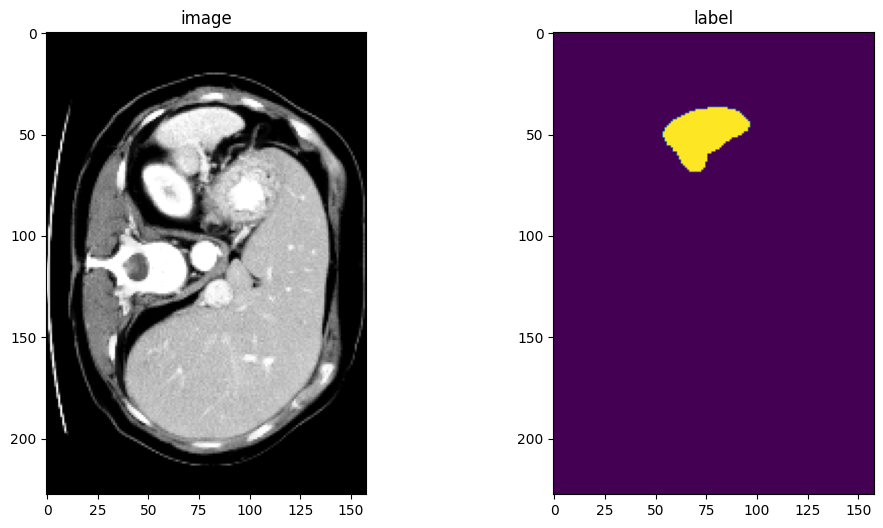

In [ ]:
# Create a dataset using validation files and the specified validation transforms
check_ds = Dataset(data=val_files, transform=val_transforms)

# Create a DataLoader with a batch size of 1 for visualization purposes
check_loader = DataLoader(check_ds, batch_size=1)

# Retrieve the first batch of data from the DataLoader
check_data = first(check_loader)

# Extract the image and label from the data
image, label = (check_data["image"][0][0], check_data["label"][0][0])

# Print the shapes of the image and label
print(f"image shape: {image.shape}, label shape: {label.shape}")

# Plot a slice of the images and labels (slice along the third dimension at index 80)
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()


## Define CacheDataset and DataLoader for training and validation

In this section, we leverage the `CacheDataset` to significantly enhance the speed of both the training and validation processes, offering a remarkable 10x acceleration compared to the conventional Dataset. To optimize performance, consider setting the `cache_rate` parameter to 1.0, enabling the caching of the entire dataset. In cases where memory constraints arise, users have the flexibility to choose a lower value for `cache_rate`. Alternatively, the option to use `cache_num` is available, allowing the system to utilize the minimum value between `cache_num` and `cache_rate`. Moreover, for those seeking to employ multi-threading capabilities during caching, the `num_workers` parameter can be configured accordingly.

Should the desire arise to revert to the conventional Dataset for experimentation or comparison purposes, simply uncomment the provided code block below.

This approach not only streamlines the training and validation procedures but also offers a dynamic and adaptable caching mechanism tailored to the user's memory constraints and processing preferences.

In [ ]:
# Create a CacheDataset for training with accelerated caching
# CacheRate is set to 1.0, caching the entire dataset for optimal performance
# NumWorkers enables multi-threading during caching for faster data loading
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)

# Alternatively, for experimentation with the regular Dataset, uncomment the line below:
# train_ds = Dataset(data=train_files, transform=train_transforms)

# Use DataLoader to load training data in batches of size 2
# Shuffle the data for randomization and apply RandCropByPosNegLabeld for data augmentation
# The resulting batch size will be 2 x 4, generating 2 batches of 4 images each for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

# Create a CacheDataset for validation with accelerated caching
# Similar to training, CacheRate is set to 1.0, caching the entire dataset for optimal performance
# NumWorkers enables multi-threading during caching for faster data loading
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)

# Alternatively, for experimentation with the regular Dataset, uncomment the line below:
# val_ds = Dataset(data=val_files, transform=val_transforms)

# Use DataLoader to load validation data in batches of size 1
# NumWorkers enables multi-threading during data loading for faster processing
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 32/32 [01:43<00:00,  3.24s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 9/9 [00:22<00:00,  2.51s/it]


During the training we loop over each image from train images, move it to GPU, apply our model on it, get the output, compare it against GT, compute loss, and apply backpropagation.
How can we loop over training data and each time apply all the data augmentation transforms we defined?

In [ ]:
device = torch.device("cuda:0")

for batch_data in train_loader:
    inputs, labels = (
        batch_data["image"].to(device),
        batch_data["label"].to(device),
    )
    print(f"Input image shape: {inputs.shape}") # should B x C X H X W X D
    print(f"Input label shape: {labels.shape}")
    break

Input image shape: torch.Size([8, 1, 96, 96, 96])
Input label shape: torch.Size([8, 1, 96, 96, 96])


# **Section 3:  Create model**
We are using UNET model, the most commonly used CNN model used for segmentation tasks in medical imaging. UNET architecture is characterized by its U-shaped structure, consisting of an encoding path for feature extraction and a symmetric decoding path for precise localization and segmentation. This architecture has proven effective in various medical image segmentation challenges, making it a popular choice for tasks such as organ segmentation, tumor detection, and anatomical structure identification. Its inherent ability to capture both local and global context makes UNET well-suited for complex and detailed segmentation tasks commonly encountered in medical image analysis.

In [ ]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
print(model)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


# **Section 4:  Define loss function, Optimizer, and Evaluation metric**

**Loss Function**:

MONAI has implemented different type of loss function as `class` object for us.

Check [this link](https://docs.monai.io/en/latest/losses.html) for all the available loss functions in MONAI.

In this tutorial, we use [DiceLoss](https://docs.monai.io/en/latest/losses.html#diceloss), the most commonly used one in segmentation task.



**Evaluation Metrics**:

During training and also in inference mode, we need to evaluate our model either on validation or test sets to check/test the generalizability of our model. To do this we need some metrics.

Check [this link](https://docs.monai.io/en/0.8.0/metrics.html) for all the available evaluation metrics in MONAI.

In this tutorial, we use [Dice coefficient](https://docs.monai.io/en/0.8.0/metrics.html#mean-dice), the most commonly used one in segmentation task.



**Optimizer**:

* The optimizer is a crucial component in training deep learning models as it updates the model's parameters based on the computed gradients during backpropagation.

* In this tutorial, we use the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), a popular choice in deep learning due to its adaptive learning rate method and efficient optimization capabilities.

* Adam stands for Adaptive Moment Estimation and combines the advantages of both AdaGrad and RMSProp optimization algorithms. It maintains separate learning rates for each parameter and adjusts them adaptively based on the exponentially decaying average of past squared gradients and past gradients.

By using the Adam optimizer, we aim to efficiently train our 3D UNet model for spleen segmentation, leveraging its adaptive learning rate and robust optimization properties to achieve optimal performance.


In [ ]:
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# **Section 5:  Execute a typical PyTorch training process**

The code iterates over epochs and performs training using the defined optimizer and loss function.
Training is conducted batch-wise, with gradients calculated and backpropagated to update the model parameters.
At specified validation intervals, the model is evaluated on the validation dataset using sliding window inference.
Dice coefficient is computed as the evaluation metric to assess segmentation accuracy.
The best model is saved based on the highest dice coefficient achieved during validation.

## breakdown the code block below:

1. **Epoch Iteration**:
   - Loop through each epoch from 1 to the maximum number of epochs specified.
   - For each epoch, print a separator and the current epoch number.

2. **Model Training**:
   - Set the model to training mode using `model.train()`.
   - Initialize variables to track epoch loss and step count.

3. **Batch Iteration**:
   - Iterate through batches in the training loader.
   - For each batch, increment the step count and extract inputs (images) and labels.

4. **Forward Pass**:
   - Pass the inputs (images) through the model to obtain the outputs.
   - These outputs represent the model's predictions for the given inputs.

5. **Loss Calculation**:
   - Compute the loss between the model outputs and the ground truth labels.
   - This loss represents how well the model's predictions match the actual labels.

6. **Backpropagation**:
   - Zero out the gradients accumulated from the previous iteration using `optimizer.zero_grad()`.
   - Perform backpropagation to compute gradients of the loss with respect to the model parameters.
   - Update the model parameters using the optimizer's optimization algorithm (`optimizer.step()`).

7. **Epoch Loss Calculation**:
   - Accumulate the loss values for each step to compute the average loss for the epoch.
   - Append the epoch's average loss to the list of epoch loss values.

8. **Validation**:
   - Perform validation at specified intervals using `if (epoch + 1) % val_interval == 0`.
   - Set the model to evaluation mode using `model.eval()` to disable dropout and batch normalization.
   - Iterate through batches in the validation loader.

9. **Sliding Window Inference**:
   - Perform sliding window inference to generate predictions for each patch of the validation images.
   - Apply post-processing transformations to the model outputs and ground truth labels.

10. **Metric Calculation**:
    - Compute the dice coefficient (a common metric for segmentation tasks) using model predictions and ground truth labels.
    - Aggregate the dice coefficient across all batches to obtain the final metric value for the validation set.

11. **Best Model Tracking**:
    - Track the best metric achieved during validation.
    - If the current metric surpasses the best metric recorded so far, update the best metric and save the model parameters.

12. **Output and Saving**:
    - Print the current epoch's mean dice coefficient and the best mean dice coefficient achieved so far, along with the corresponding epoch number.
    - Save the model parameters to a file if a new best metric is achieved.


In [ ]:
# Define maximum number of epochs and validation interval
max_epochs = 100
val_interval = 2

# Initialize variables for tracking best metric and associated epoch
best_metric = -1
best_metric_epoch = -1

# Lists to store epoch loss values and metric values
epoch_loss_values = []
metric_values = []

# Define post-processing transforms for predictions and labels
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# Iterate over epochs
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    # Set model to training mode
    model.train()
    epoch_loss = 0
    step = 0

    # Iterate over batches in the training loader
    for batch_data in train_loader:
        step += 1
        # Move inputs and labels to GPU
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute loss
        loss = loss_function(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        # Update epoch loss
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")

    # Calculate average epoch loss
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Perform validation at specified intervals
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                # Define ROI size and sliding window batch size
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                # Perform sliding window inference
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # Compute dice metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # Aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # Reset the status for the next validation round
            dice_metric.reset()

            # Append metric value to list
            metric_values.append(metric)

            # Check if current metric is better than best metric
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                # Save the model with the best metric
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")

            # Print current and best metric values
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


----------
epoch 1/100
1/16, train_loss: 0.6453
2/16, train_loss: 0.6767
3/16, train_loss: 0.6707
4/16, train_loss: 0.6617
5/16, train_loss: 0.6735
6/16, train_loss: 0.6326
7/16, train_loss: 0.6389
8/16, train_loss: 0.6488
9/16, train_loss: 0.6310
10/16, train_loss: 0.6090
11/16, train_loss: 0.6506
12/16, train_loss: 0.6391
13/16, train_loss: 0.6611
14/16, train_loss: 0.6297
15/16, train_loss: 0.6396
16/16, train_loss: 0.6137
epoch 1 average loss: 0.6451
----------
epoch 2/100
1/16, train_loss: 0.6237
2/16, train_loss: 0.6176
3/16, train_loss: 0.6079
4/16, train_loss: 0.6257
5/16, train_loss: 0.6159
6/16, train_loss: 0.6083
7/16, train_loss: 0.5986
8/16, train_loss: 0.6295
9/16, train_loss: 0.6180
10/16, train_loss: 0.6147
11/16, train_loss: 0.6134
12/16, train_loss: 0.6072
13/16, train_loss: 0.6286
14/16, train_loss: 0.5791
15/16, train_loss: 0.5769
16/16, train_loss: 0.5512
epoch 2 average loss: 0.6073
saved new best metric model
current epoch: 2 current mean dice: 0.0466
best mean d

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.1783 at epoch: 18


# **Section 6:  Understanding Training Curves**


1. **Epoch Average Loss Plot**:
   - The left subplot displays the epoch average loss over the training epochs.
   - The x-axis represents the epoch number, while the y-axis represents the loss value.
   - As training progresses, we expect the loss to decrease gradually. A consistent decrease indicates effective learning.
   - Watch out for sudden spikes or fluctuations in the loss curve, which may indicate issues like unstable training or poor convergence.
   - Overfitting can be observed if the training loss continues to decrease while the validation loss starts to increase or remains stagnant.

2. **Validation Mean Dice Plot**:
   - The right subplot illustrates the mean dice coefficient on the validation set across epochs.
   - The x-axis represents the epoch number, and the y-axis represents the mean dice coefficient.
   - A rising trend in the mean dice coefficient indicates improving segmentation performance on the validation set.
   - A plateau or decline in the mean dice coefficient may indicate overfitting or insufficient model capacity.
   - If the mean dice coefficient is consistently high and stable, it suggests that the model has learned the segmentation task effectively.

Understanding these training curves helps in monitoring the training process, diagnosing issues such as overfitting, and determining when to stop or continue training to achieve optimal model performance.


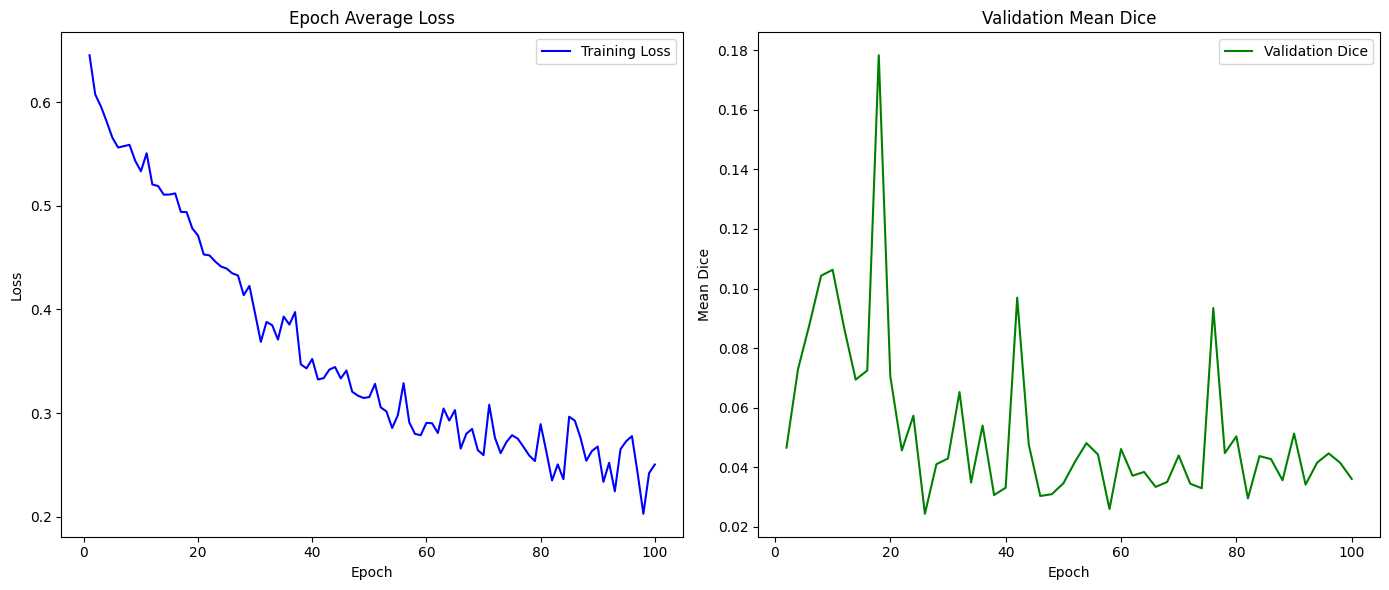

In [ ]:
# Define plot parameters
plt.figure(figsize=(14, 6))

# Plot Epoch Average Loss
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
x_loss = [i + 1 for i in range(len(epoch_loss_values))]
y_loss = epoch_loss_values
plt.plot(x_loss, y_loss, color='blue', label='Training Loss')
plt.legend()

# Plot Validation Mean Dice
plt.subplot(1, 2, 2)
plt.title("Validation Mean Dice")
plt.xlabel("Epoch")
plt.ylabel("Mean Dice")
x_dice = [val_interval * (i + 1) for i in range(len(metric_values))]
y_dice = metric_values
plt.plot(x_dice, y_dice, color='green', label='Validation Dice')
plt.legend()

plt.tight_layout()
plt.show()

# **Section 7:  Deploy the best saved model**
This code segment demonstrates how to deploy the best saved model and visualize its segmentation outputs on validation data slices.



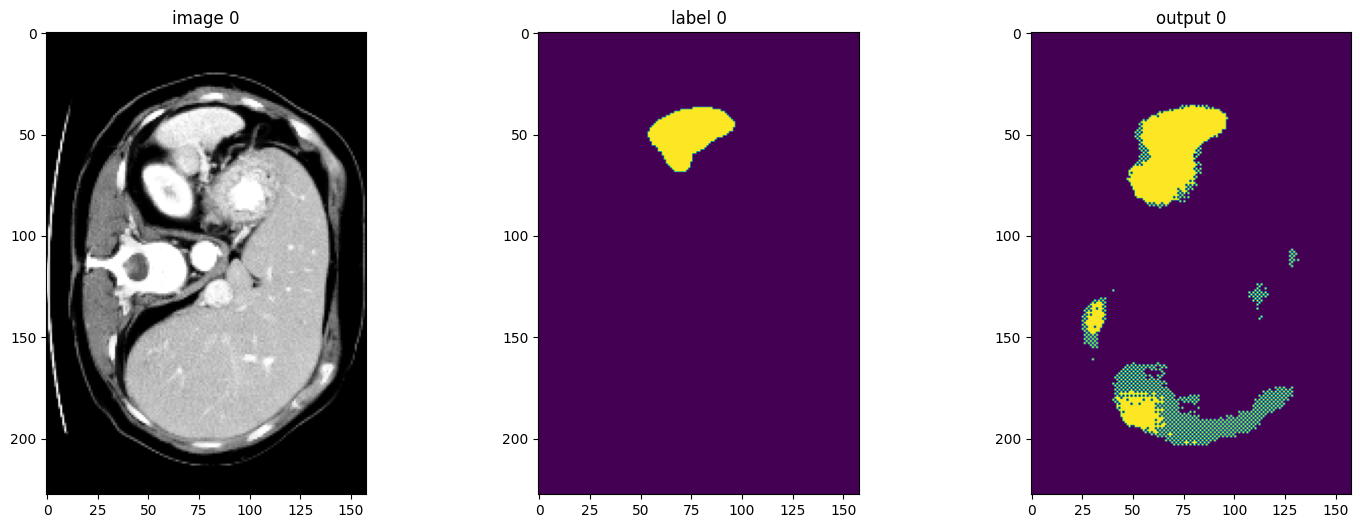

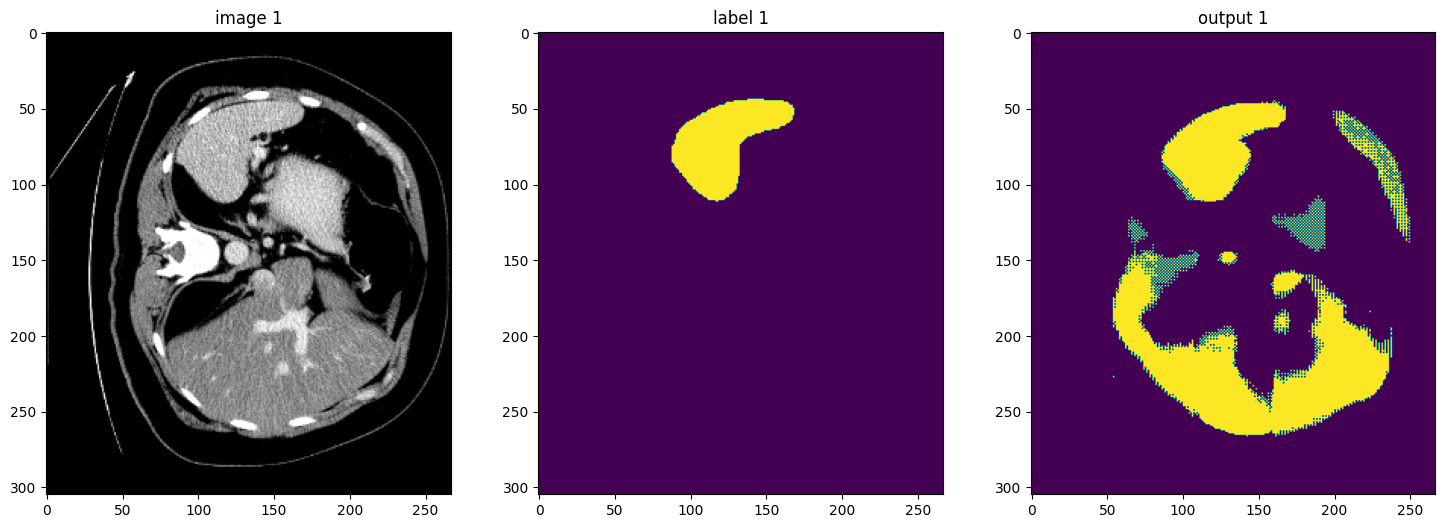

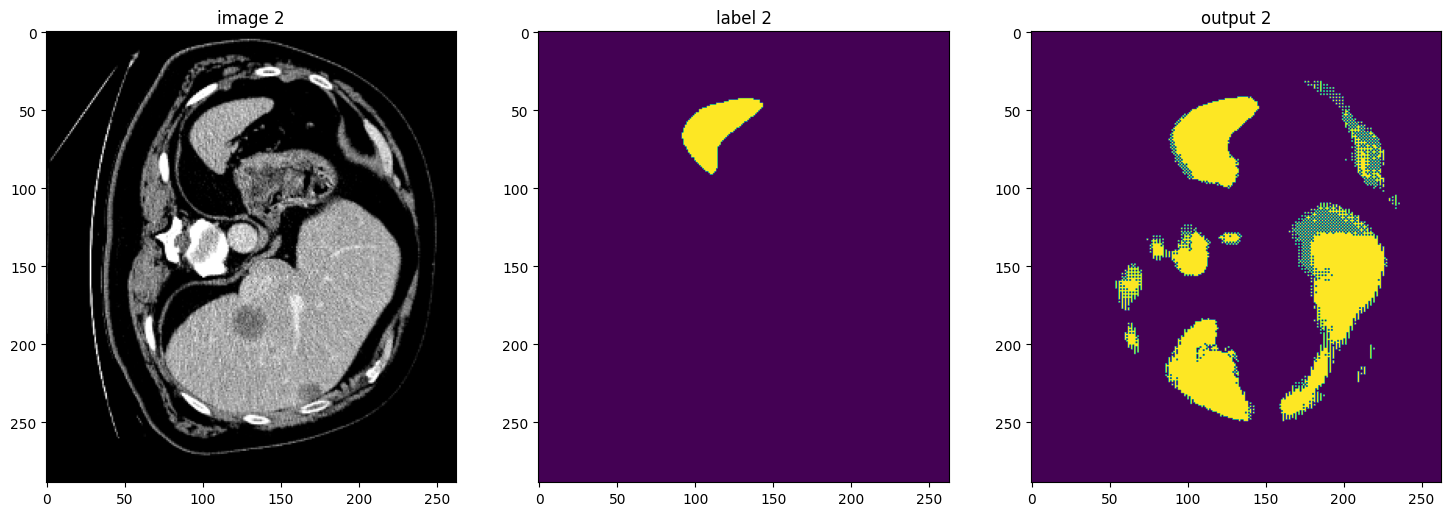

In [ ]:
# Load the best saved model parameters
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

# Set the model to evaluation mode
model.eval()

# Perform inference on validation data using the best model
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device),
                                               roi_size, sw_batch_size, model)

        # Plot the slices
        plt.figure("check", (18, 6))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")

        # Plot ground truth label
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])

        # Plot model output
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()

        # Break loop after 3 iterations for visualization
        if i == 2:
            break


# **Section 8:  Model Performance on Test Test**
1. **Test Dataset Preparation**:
   - Load the list of test images and create a dictionary with image paths.

2. **Original Test Transforms**:
   - Define transforms to preprocess test images similar to the training and validation sets.

3. **Original Test Dataset and Loader**:
   - Create a dataset and DataLoader for the original test dataset.

4. **Post-processing Transforms**:
   - Define transforms to post-process the model predictions and labels.

5. **Model Loading and Evaluation**:
   - Load the best saved model parameters and set the model to evaluation mode.
   - Iterate through the original test loader to perform inference and evaluation.
   - Apply post-processing transforms to the model outputs and ground truth labels.

6. **Test Set Metric Calculation**:
   - Compute the dice coefficient (metric) on the test set using the model predictions and ground truth labels.
   - Aggregate the final mean dice coefficient result.

7. **Print Test Set Metric**:
   - Print the metric value obtained on the test set, indicating the model's performance.


In [ ]:
print(data_dir)

/tmp/tmp27x49r3l/Task09_Spleen


In [ ]:
# Define the list of test images
# originally we do this on test set, but here for this dataset we don't have labels for test set because it's a challenge dataset
# so here the mean dice s
# Create test data dictionary

test_data = val_files

# Define original test transforms
test_org_transforms = val_transforms

# Create original test dataset
test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

# Create data loader for original test dataset
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

# Define post-processing transforms
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# Load the best saved model parameters
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

# Evaluate model performance on test set
with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        test_labels = test_data["label"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        # Perform sliding window inference
        test_outputs = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
        test_labels = [post_label(i) for i in decollate_batch(test_labels)]
        # Compute metric for current iteration
        dice_metric(y_pred=test_outputs, y=test_labels)

    # Aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # Reset the status for the next validation round
    dice_metric.reset()

# Print the metric on the test set
print("Metric on Test Set: ", metric_org) # as we used validation data now should be the same as best score


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Metric on Test Set:  0.17833952605724335
